# About the data

Dataset contain 20 clean and 20 dirty plates images in the train dataset and hundreds of plates in the test dataset. It is located on the Kaggle website and is part of the Kaggle competition "Cleaned vs Dirty V2".
Dataset link: https://www.kaggle.com/competitions/platesv2/overview

*File descriptions*
- plates.zip - dataset with train and test folders
- sample_submission.csv - a sample submission file in the correct format

*Data fields*
- id - id of an image from the test folder. If image name is 0123.jpg its id will be 0123
- label - predicted label. One of: dirty, cleaned

The goal is to train a model who can classify if a plate is clean or dirty. 

# Import libraries

In [1]:
import zipfile
import os, warnings
print(os.listdir("../input"))

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import gridspec

from tensorflow.keras import optimizers
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import glob
from sklearn.utils import shuffle

['platesv2']


In [2]:
with zipfile.ZipFile('../input/platesv2/plates.zip', 'r') as zip_obj:
        zip_obj.extractall('/kaggle/working/') 
print(os.listdir('/kaggle/working/'))

data_root = '/kaggle/working/plates/' 
print(data_root)
print(os.listdir(data_root))

['__MACOSX', '__notebook__.ipynb', 'plates']
/kaggle/working/plates/
['train', 'test', '.DS_Store']


# Model configuration options

In [3]:
#image dimensions and batch size
img_rows, img_cols = 224, 224 #specify width and height of the images
batch_size = 64

#training parameters
n_epochs = 5 
n_classes = 2 
validation_split = 0.2 #20% of the data for validation
verbosity = 1 #We want to be able to see the model output, verbosity=1 or True

#path specifies the location where train data is stored
path_train = "/kaggle/working/plates/train/"
#path_test specifies the location where test data is stored
path_test = "/kaggle/working/plates/"

#image input shape (w, h, d)
input_shape = (img_rows, img_cols, 3) #RGB

#cleaned and dirty labels
labels = ['cleaned', 'dirty']

#value of 10 for random number generation in Python environment
seed = 10

# Image Augmentation

ImageDataGenerator in Keras is used to preprocess and augment image data for training deep learning models by applying various transformations such as scaling, rotation, flipping, and zooming.

- validation_split - % of the data for validation;
- rescale=1.0/255 - Scale the image pixel values to the range of [0, 1];
- rotation_range - randomly rotates images;
- width_shift_range - Randomly shifts the width of the images by up to % of the total width; 
- height_shift_range - Randomly shifts the width of the images by up to % of the total height;
- shear_range - Shearing is a transformation that skews the image along one axis;
- zoom_range - Randomly zooms into images;
- horizontal/vertical_flip - randomply flip inputs horizontally/verticlly. This augmentation technique is useful for training models that need to recognize objects irrespective of their orientation;
- fill_model - When transformations like shifting or rotating introduce empty pixels, fill_mode='nearest' fills them with the nearest pixel value. 

In [4]:
train_datagen = ImageDataGenerator(
    validation_split = validation_split,
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    validation_split = validation_split,
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

"flow_from_directory" allows us to load batches of images from a directory on disk, applying specified data augmentation techniques in real-time during model training.

- directory: Specifies the path to the target directory containing the images;
- classes: Optional parameter that specifies the list of class subdirectories to consider within the directory;
- seed: Sets the seed for the random number generator. This ensures reproducibility in data augmentation and shuffling;
- batch_size: Specifies the size of the batches of data (number of images) that the generator yields during each iteration;
- class_mode: Specifies the type of label arrays returned by the generator.
1. 'binary': For binary classification tasks (e.g., cats vs dogs).
2. 'categorical': For multi-class classification tasks with one-hot encoded labels.
3. 'sparse': For multi-class classification tasks with integer labels.
4. 'input': Returns the images without any labels, useful for model prediction on new data.
- shuffle: Determines whether to shuffle the data order. Shuffling helps in reducing bias during training by presenting the data in random order;
- target_size: Specifies the dimensions to which all images found will be resized;
- subset: Specifies whether this generator will generate data for the 'training' or 'validation' subset of the dataset.

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory = path_train,
    classes = labels,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'training'
)

validation_generator = validation_datagen.flow_from_directory(
    directory = path_train,
    classes = labels,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    classes = ["test"],
    batch_size = 1,
    class_mode=None,
    shuffle = False,
    target_size=(img_rows, img_rows)
)

Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 744 images belonging to 1 classes.


We have 40 images with 2 classes in the training set, labeled as cleaned and dirty. We split it on 32 images for the training and 8 for validation. In the test set we have 744 images with 1 class. This dataset is not labeled.

# Visualization

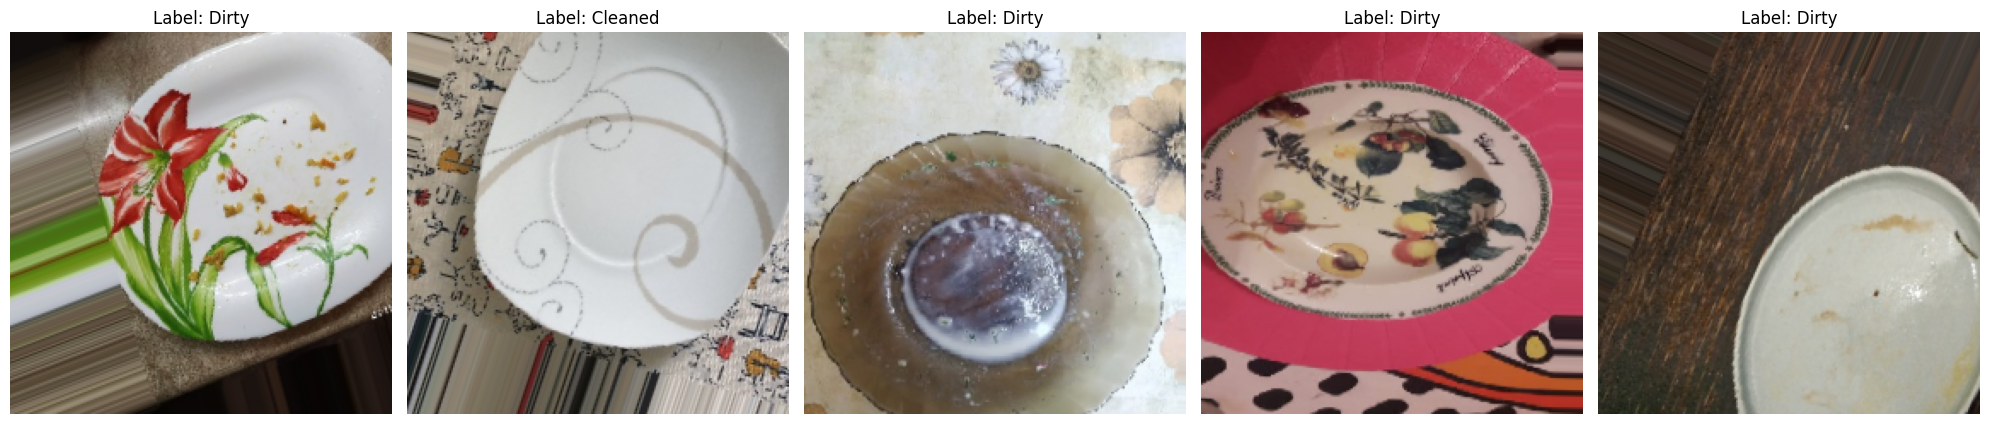

In [6]:
# Generate 5 random indexes to select batches from the train_generator
random_indices = np.random.randint(len(train_generator), size=5)

# Plot the images and print their labels
plt.figure(figsize=(20, 10))
for i, rand_idx in enumerate(random_indices):
    batch = train_generator[rand_idx]
    images = batch[0]  # Get the batch of images
    labels = batch[1]  # Get the batch of labels
    
    # Number of images in the current batch
    num_images_in_batch = images.shape[0]
    
    # Randomly select an image from the batch
    img_idx = np.random.randint(num_images_in_batch)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[img_idx])
    plt.title('Label: {}'.format('Cleaned' if labels[img_idx] == 0 else 'Dirty'))
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model

## Base model

Pre-trained models are networks that have previously been trained on some large datasets. These models form the basis of transfer learning. In computer vision, some popular pre-trained models include: VGG-16, VGG-19, InceptionV3, XCeption, and ResNet-50.

In this model we will use VGG-16.

The default input image size for VGG-16 is 224x224 pixels.

- include_top: Setting include_top=False means that only the convolutional base of the VGG-16 model will be loaded, excluding the fully connected layers at the top;

- weights: Indicates that the pre-trained weights of the VGG-16 model trained on the ImageNet dataset will be used;

- input_shape: (img_rows, img_cols, RGB).



In [7]:
basemodel = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
#freeze all layers in a basemodel, meaning that their weights will not be updated during the training process of the entire model
for layer in basemodel.layers: 
    layer.trainable = False

## Head model

In the context of transfer learning, the head model refers to the final layers of a neural network that are added on top of a pre-trained base model. Transfer learning leverages a model that has already been trained on a large dataset (e.g., ImageNet) for feature extraction, and the head model is customized for the specific task or dataset we are working on.

In [9]:
# Build the model
model = Sequential()
model.add(basemodel)
model.add(Flatten())  
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

## Compiling the model

Compiling a model in Keras is a crucial step in the workflow that prepares the model for training. This step involves specifying the optimizer, loss function, and evaluation metrics to be used during training.
- *The optimizer* controls how the model's weights are updated during training. Common optimizers include Adam, SGD, and RMSprop;
- *The loss function* measures how well the model's predictions match the true labels. The choice depends on the type of problem:
For Classification: categorical_crossentropy (for multi-class classification) or binary_crossentropy (for binary classification).
For Regression: mean_squared_error or mean_absolute_error;
- *Metrics* help evaluate the performance of the model during training and validation. Common metrics include accuracy for classification and mean_squared_error for regression. Metric tracks accuracy as the evaluation metric during training and validation.

In [10]:
# Compiling the model with the specified loss function, optimizer, and metrics
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Fit and train the model

**Early stopping** is regularization technique that prevents overfitting by stopping training when the model's performance on the validation set stops improving
- *monitor='val_loss':* Tracks the validation loss to determine when to take action;
- *patience=5:* training will stop if there is no improvement in the metric for 5 consecutive epochs;
- *restore_best_weights=True:* Restores the model weights to the best state observed during training based on the monitored metric.

**ReduceLROnPlateau callback** is designed to dynamically adjust the learning rate during training based on the performance of model
- *monitor='val_loss'*: Observes the validation loss to decide when to adjust the learning rate.
- *factor=0.5:* Reduces the learning rate by 50% when the validation loss plateaus.
- *patience=5:* Waits for 5 epochs with no improvement in validation loss before making the adjustment.
- *min_lr=1e-6:* Ensures the learning rate does not drop below 1e-6.

In [11]:
early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Fit the model
history = model.fit(
    train_generator,
    epochs=150,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1 #detailed updates on the training process
)

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724776691.821288      88 service.cc:145] XLA service 0x7d03dc015270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724776691.821340      88 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5312 - loss: 11.0156

I0000 00:00:1724776702.813645      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.5312 - loss: 11.0156 - val_accuracy: 0.3750 - val_loss: 9.8432 - learning_rate: 0.0010
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step - accuracy: 0.6562 - loss: 9.6015 - val_accuracy: 0.5000 - val_loss: 8.9912 - learning_rate: 0.0010
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step - accuracy: 0.5938 - loss: 8.6113 - val_accuracy: 0.3750 - val_loss: 8.3377 - learning_rate: 0.0010
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - accuracy: 0.6250 - loss: 7.6963 - val_accuracy: 0.3750 - val_loss: 7.7472 - learning_rate: 0.0010
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step - accuracy: 0.7500 - loss: 6.7773 - val_accuracy: 0.3750 - val_loss: 7.1435 - learning_rate: 0.0010
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - accuracy: 0.8125 - loss: 6.0575 - val_accuracy: 0.3750 - val_loss: 6.5901 - learning_rate: 0.0010
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step - accuracy: 0.6875 - loss: 5.5909 - val_accuracy: 0.375

Minimum validation loss: 1.580411434173584


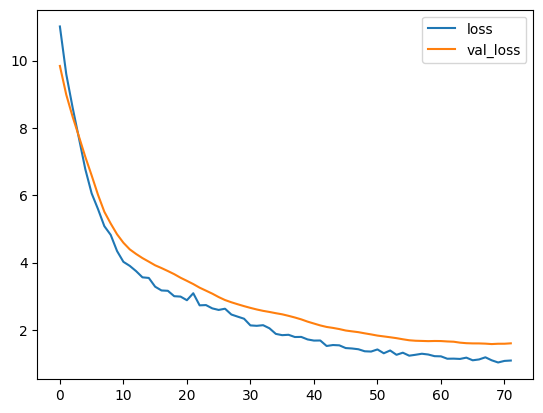

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

## Evaluation

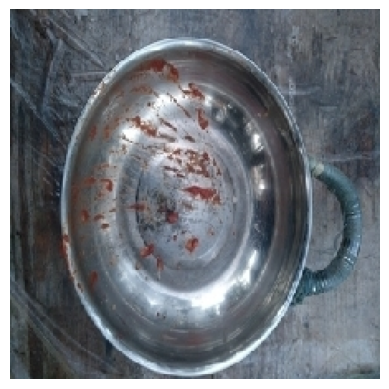

Prediction for custom image: dirty


In [13]:
# Assuming your image dimensions
IMG_DIM = (224, 224)

# Read in all O and R test images file paths. Shuffle and select 50 random test images.
test_files = glob.glob('/kaggle/working/plates/test/*.jpg')  # Adjust file extension as per your image format
test_files = shuffle(test_files)[:50]  # Shuffle and select 50 random images

# Extract images and labels
test_imgs = []
test_labels = []

for img in test_files:
    # Load and resize image
    img_array = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM))
    test_imgs.append(img_array)

# Convert lists to numpy arrays
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

# Standardize
test_imgs_scaled = test_imgs.astype('float32') / 255.0

# Define functions for label conversion
def class2num(label):
    return 0 if label == 'cleaned' else 1

def num2class(num):
    return 'cleaned' if num < 0.5 else 'dirty'

# Convert labels to numerical format for model training
test_labels_enc = np.array([class2num(label) for label in test_labels])

# Load or define your model
# model = tf.keras.models.load_model('path_to_your_model.h5')  # Make sure to load your model if it's not defined

# Predict using the model
predictions_model_history = model.predict(test_imgs_scaled, verbose=0)

# Convert predictions from probabilities to class labels
predictions_model_labels = np.array([num2class(pred[0]) for pred in predictions_model_history])

# Example of predicting on a single custom image
custom_im = test_imgs_scaled[2]  # Assuming index 2 is a valid index in your test set

plt.imshow(custom_im)
plt.axis('off')
plt.show()

# Reshape and predict with the model
custom_im = custom_im.reshape((1, IMG_DIM[0], IMG_DIM[1], 3))  # Reshape to match model input shape
prediction_custom_im = model.predict(custom_im, verbose=0)

# If predictions are probabilities, use the following line
print(f"Prediction for custom image: {num2class(prediction_custom_im[0][0])}")


# Key Findings

The training accuracy is very high, indicating that the model performs very well on the training data. The validation accuracy is lower than the training accuracy, suggesting that the model performs well on the training data but does not give equally good results on the validation data. Similarly, the training loss is lower than the validation loss, which further supports the idea that the model is overfitting.

**Next Steps**
- Dropout, L2 regularization, data augmentation and early stopping were used to reduce overfitting. The suggestion is to try increasing the dropout or changing the learning rate for better results.
- We have little training data, so VGG16 was used as the base model, the suggestion is to explore alternative base models that would potentially give better results.